# Hito 1 Minería de Datos
## Datos astronómicos del SDSS DR 10

### Introducción
En el ámbito de la astronomía, el estudio de la evolución cósmica requiere que identifiquemos cuáles objetos en el cielo están más cerca, las estrellas y galaxias, o galaxias con un alto redshift y agujeros negros supermasivos (los denominados QSOs).

Por un lado, la espectroscopía puede ser usada para medir redshifts de los diferentes objetos cósmicos, y poder diferenciar entre los diferentes tipos de fuentes, sin embargo la mayoría surveys deben caracterizar los objetos solamente basandose en la medición de imágenes.

Nuestra pregunta de investigación es ¿Podemos classificar y predecir el redshift de objetos usando fotometría?

### Exploración de datos

Los datos usados para este proyecto es el SDSS DR 10 (link?), el cual posee más de 3 millones de espectros públicos con información relevante. 

- estadisticas
- patrones iniciales

### Propuesta experimental
- estrategia metodologica

### Experimento preliminar
- implementación y análisis de resultados

### Anexos (opcional)
- graficos y códigos complementarios

In [35]:
import gzip
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# Definiendo las columnas pues los datos no las traen
columnas = ["objID", "RAdeg", "Dedeg", 
            "umag", "gmag", "rmag", "imag", "zmag", 
            "u'mag", "g'mag", "r'mag", "i'mag", "z'mag",
            "specID", "subclass", "z", "Qf"]

with gzip.open("dame_qso.dat.gz", "rt") as f:
    df = pd.read_csv(f, delim_whitespace=True, names=columnas, comment='#')

Cantidad de datos originalmente (3602210, 17)
Cantidad de datos sin nan (3602210, 17)


In [40]:
print("Datos inicialmente: " + str(df.shape))

# Filtros

# Nos aseguramos que es una subclase válida y que la calidad sea alta

subclases = ["BROADLINE","STARBURST" ,"STARBURST_BROADLINE" , "STARFORMING", "STARFORMING_BROADLINE", "AGN", "AGN_BROADLINE"]
df = df[df["subclass"].isin(subclases) & df["Qf"] == 1]
print("Cantidad de datos luego de filtrar: " + str(df.shape))

Datos inicialmente: (73875, 17)
Cantidad de datos luego de filtrar: (73875, 17)


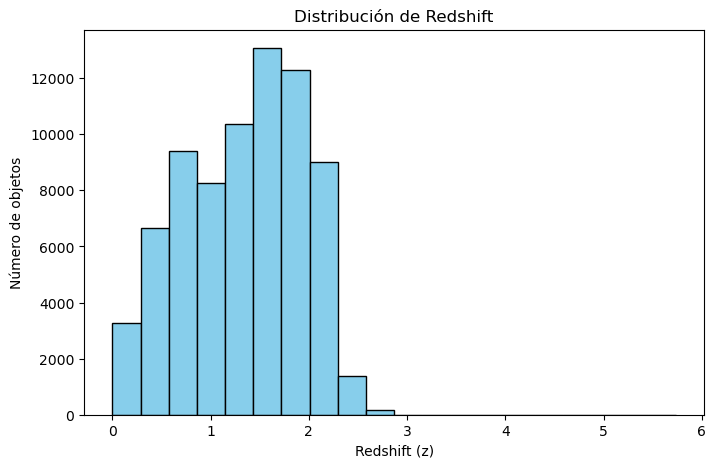

In [44]:
import matplotlib.pyplot as plt
# Veamos la distribución de redshift de nuestros datos

z = df["z"]
plt.figure(figsize=(8,5))
plt.hist(z, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Redshift (z)")
plt.ylabel("Número de objetos")
plt.title("Distribución de Redshift")
plt.show()

In [3]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(128,64),
                    solver='lbfgs',   # L-BFGS ≈ Quasi-Newton
                    alpha=1e-5,
                    max_iter=1000,
                    random_state=42)